In [2]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [28]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from source.visualization. training_visualization import plot_grad_flow_hist
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import time
import torch
from einops.einops import rearrange

In [4]:
crop_size = 640
transformation_threshold = 0.3
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"
use_train_data = True

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]))

In [5]:
from source.datasets.brain_dataset import collate_fn

In [6]:
batch_size = 2

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
    drop_last=False,
    collate_fn=collate_fn
)

In [7]:
use_l2_with_standard_deviation = True

In [25]:
learning_rate = 0.0007
weight_decay = 0.0015
use_coarse_context = True
temperature = 0.2  # Dont decrease this value, it will yield in overflows (similarity_matrix)

device = "cuda" if torch.cuda.is_available() else "cpu"

block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).to(device=device)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).to(device=device)

coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(device=device)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).to(device=device)
fine_matching = FineMatching(return_standard_deviation=use_l2_with_standard_deviation).to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [26]:
coarse_loss = "focal"
alpha = 0.55
gamma = 1.5
fine_loss = "l2_std" if use_l2_with_standard_deviation else "l2"

tensor([[[15.0666, 14.8312, 13.8985,  ..., 13.1375, 13.7411, 12.6566],
         [15.2794, 15.5157, 15.2672,  ..., 12.7859, 13.4823, 12.9274],
         [14.7535, 14.8311, 14.5835,  ..., 12.5505, 13.7114, 13.0019],
         ...,
         [13.3938, 13.5734, 12.3772,  ..., 14.8807, 15.7099, 14.9913],
         [12.2812, 12.0518, 11.6495,  ..., 14.5680, 15.4998, 14.7880],
         [12.0654, 11.5978, 11.9499,  ..., 15.2930, 15.5656, 15.1563]],

        [[15.3571, 14.8951, 14.8444,  ..., 13.3473, 14.0667, 12.7443],
         [14.6319, 15.0535, 14.2705,  ..., 12.9753, 14.0103, 12.8737],
         [14.0919, 14.2176, 13.9529,  ..., 12.0350, 12.7124, 12.2593],
         ...,
         [12.9987, 12.4954, 11.5502,  ..., 15.6062, 15.9872, 14.4018],
         [13.2670, 12.5431, 12.2267,  ..., 15.1698, 15.4240, 14.6860],
         [13.1538, 12.9593, 12.0825,  ..., 15.1751, 15.7847, 14.7731]]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([[[24.6957, 24.9669, 24.9724,  ..., 16.0922, 18.5046, 19.6573

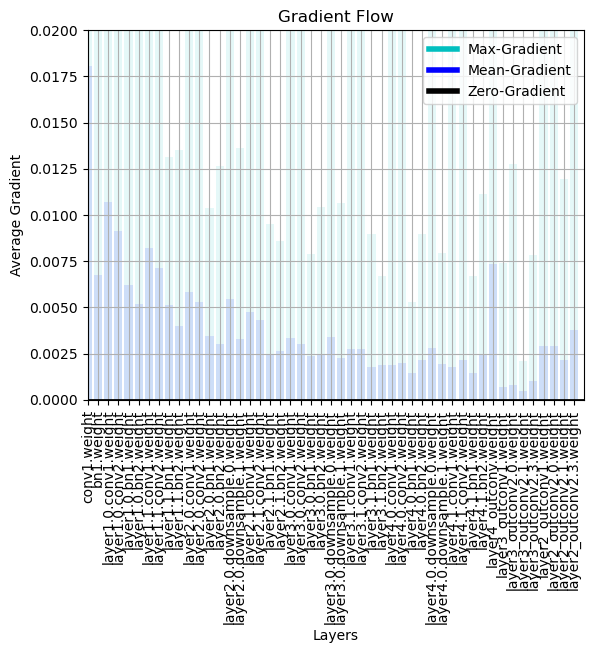

Epoch: 0, Duration: 12.01 sec, Latest Coarse Loss: 6.8402, Latest Fine Loss: 1.4143
tensor([[[31.3274, 30.5338, 29.9474,  ..., 27.5446, 27.7923, 28.3465],
         [30.1682, 30.3832, 30.2704,  ..., 25.5927, 25.9473, 26.8025],
         [28.0823, 28.8584, 29.2792,  ..., 22.7025, 23.0965, 24.2121],
         ...,
         [20.4115, 21.3879, 21.6741,  ..., 21.5137, 21.6087, 22.9046],
         [20.8320, 21.8628, 22.3111,  ..., 20.5341, 20.6844, 22.1758],
         [21.7600, 23.0075, 23.4386,  ..., 21.6794, 21.9280, 23.4641]],

        [[34.0828, 34.1286, 33.9231,  ..., 27.5393, 27.8322, 28.0690],
         [34.1936, 34.7103, 34.4905,  ..., 27.3998, 27.7241, 27.8353],
         [34.0955, 34.6063, 34.4965,  ..., 27.2438, 27.5855, 27.7765],
         ...,
         [23.6929, 23.0454, 23.1151,  ..., 31.9115, 31.8459, 31.9011],
         [24.1482, 23.5362, 23.6018,  ..., 32.0313, 32.0644, 32.1393],
         [25.4932, 24.8441, 24.9624,  ..., 32.2303, 32.3242, 32.6520]]],
       device='cuda:0', grad_fn=

KeyboardInterrupt: 

In [27]:
print_frequency = 5
for epoch in range(100):
    epoch_start_time = time.time()
    for (
        image_1_crop,
        image_2_crop,
        match_matrix,
        relative_coordinates,
        _,
    ) in dataloader_train:
        image_1_crop = image_1_crop.to(device=device)
        image_2_crop = image_2_crop.to(device=device)
        match_matrix = match_matrix.to(device=device)
        relative_coordinates = relative_coordinates.to(device=device)

        optimizer.zero_grad()

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)

        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

        coarse_matches_ground_truth = {
            "batch_indices": match_matrix.nonzero()[:, 0],
            "row_indices": match_matrix.nonzero()[:, 1],
            "column_indices": match_matrix.nonzero()[:, 2]
        }

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_ground_truth,
            fine_height=160,
            coarse_height=40,
        )

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        predicted_relative_coordinates = fine_matching(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        if coarse_loss == "focal":
            coarse_loss_value = coarse_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma)
        
        elif coarse_loss == "cross_entropy":
            coarse_loss_value = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix)

        if fine_loss == "l2":
            fine_loss_value = fine_l2_loss(
            coordinates_predicted=predicted_relative_coordinates,
            coordinates_ground_truth=relative_coordinates,
        )

        elif fine_loss == "l2_std":
            fine_loss_value = fine_l2_loss_with_standard_deviation(
            coordinates_predicted=predicted_relative_coordinates,
            coordinates_ground_truth=relative_coordinates,
        )

        loss = coarse_loss_value + fine_loss_value
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        coarse_loss_history.append(coarse_loss_value.cpu().item())
        fine_loss_history.append(fine_loss_value.cpu().item())

        if torch.isnan(coarse_matches["confidence_matrix"]).all():
            print("coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training.")
            break
    if torch.isnan(coarse_matches["confidence_matrix"]).all():
        print("coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training.")
        break

    epoch_duration = time.time() - epoch_start_time
    if epoch % print_frequency == 0 or epoch == (100 - 1):
        plot_grad_flow_hist(backbone.named_parameters())
        print(f"Epoch: {epoch}, Duration: {epoch_duration:.2f} sec, Latest Coarse Loss: {coarse_loss_value:.4f}, Latest Fine Loss: {fine_loss_value:.4f}")

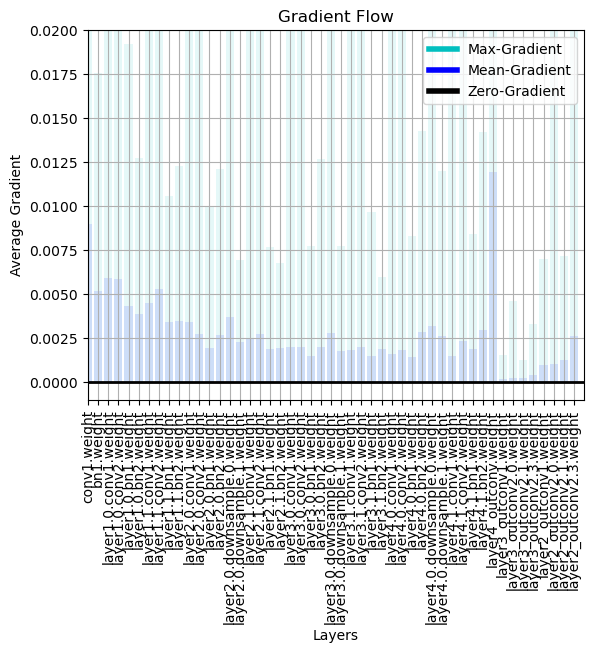

In [ ]:
import matplotlib.pyplot as plt
plot_grad_flow_hist(backbone.cpu().named_parameters()) # version 1

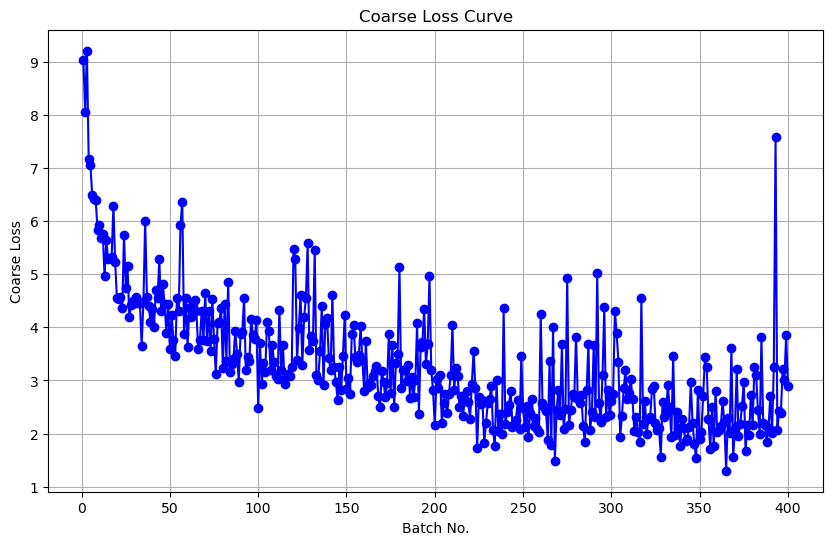

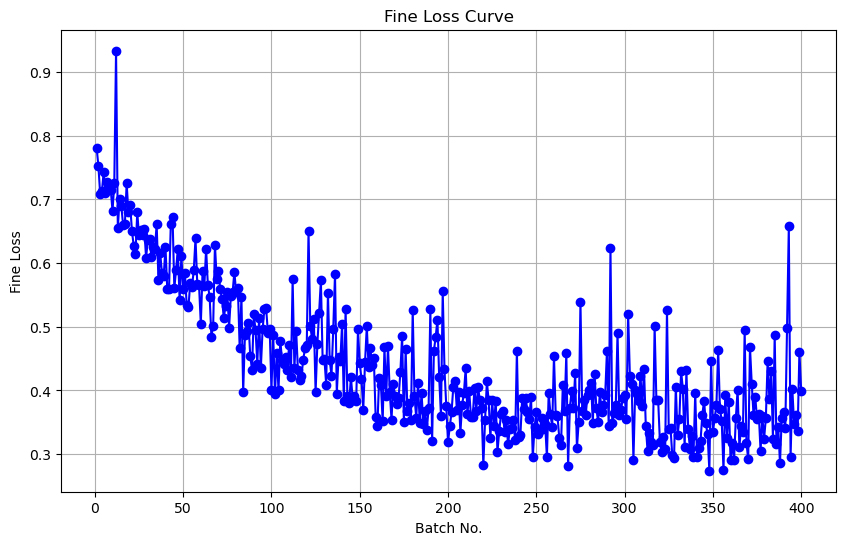

In [ ]:
plot_loss_curve(coarse_loss_history, title="Coarse Loss Curve", ylabel="Coarse Loss")
plot_loss_curve(fine_loss_history, title="Fine Loss Curve", ylabel="Fine Loss")

In [ ]:
from source.miscellaneous.model_saving import save_model

In [ ]:
hyperparameters = {
    "lr":learning_rate,
    "wd": weight_decay,
    "coarse_context": use_coarse_context,
    "img_size": "3344_3904",
    "ResNet": "16_4",
    "transform_threshold":transformation_threshold,
    "temp": temperature,
    "bs": batch_size,
    "coarse_loss": coarse_loss,
    "fine_loss": fine_loss,
    "train": use_train_data
}

if coarse_loss == "focal":
    hyperparameters["gamma"]=gamma
    hyperparameters["alpha"]=alpha



models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
save_model(models, hyperparameters=hyperparameters, coarse_loss_history=coarse_loss_history, fine_loss_history=fine_loss_history)

'../../models/lr0p0007_wd0p0015_coarse_contextFalse_img_size3344_3904_ResNet16_4_transform_threshold0p3_temp0p2_bs2_coarse_lossfocal_fine_lossl2_std_trainTrue_gamma1p5_alpha0p55_v3'